In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants import R_earth, R_sun
from batman import TransitParams, TransitModel
import astropy.units as u
import numpy as np

In [2]:
from scipy.interpolate import interp1d
t18, f18 = np.load('detrended_photometry2018.npy').T
t17, f17 = np.load('detrended_photometry2017.npy').T
t16, f16 = np.load('detrended_photometry2016.npy').T
t15, f15 = np.load('detrended_photometry2015.npy').T

In [ ]:
def duration_b_to_a_inc(P, T14, b, RpRs, eccentricity, omega):
    '''
    Convert from duration and impact param to a/Rs and inclination
    '''
    beta = (1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))
    C = np.sqrt(1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))
    i = np.arctan(beta * np.sqrt((1 + RpRs)**2 - b**2)/(b*np.sin(T14*np.pi/(P*C))))
    aRs = b/(np.cos(i) * beta)
    return aRs, np.degrees(i)

In [ ]:
import emcee
import batman 
from copy import deepcopy
import celerite
from celerite import terms
from celerite.modeling import Model
from corner import corner
from multiprocessing import Pool


import sys
sys.path.insert(0, '/Users/bmmorris/git/shocksgo/')
import astropy.units as u
from shocksgo import power_spectrum, generate_solar_fluxes

scatters = []

b_range = np.arange(0, 1, 0.1)

for b in b_range: 
    
    params = TransitParams()
    params.per = 365.25
    params.rp = float(R_earth/R_sun)
    params.a = float(1*u.AU/R_sun)

    params.inc = np.degrees(np.arccos(b / params.a))

    # Sing 2009: https://arxiv.org/pdf/0912.2274.pdf
    params.u = [0.45, 0.19]
    params.limb_dark = "quadratic"

    params.ecc = 0
    params.w = np.pi/2
    params.t0 = 0

    times = np.concatenate([t15 / 60 / 60 / 24,
                            t16 / 60 / 60 / 24 + 365.25, 
                            t17 / 60 / 60 / 24 + 2*365.25, 
                            t18 / 60 / 60 / 24 + 3*365.25]) - (t15.mean() / 60 / 60 / 24)
    fluxes = np.concatenate([f15, f16, f17, f18])

    fluxes += 1 # interp_virgo(times) + 1

    m = TransitModel(params, times)
    fluxes *= m.light_curve(params)
    errors = np.ones_like(fluxes) * 1e-6
    
#     t, f, k = generate_solar_fluxes(duration=10*u.min)

    class MeanModel(Model):
#         parameter_names = 'per, rp, t14, b, t0'.split(', ')

        parameter_names = 'rp, t14, b'.split(', ')

        def get_value(self, t):
            trial_params = deepcopy(params)
            trial_params.rp = self.rp
#             trial_params.per = self.per
            a, inc = duration_b_to_a_inc(trial_params.per, self.t14, self.b, self.rp, 0, 90)
            trial_params.inc = inc
            trial_params.a = a
#             trial_params.t0 = self.t0

            m = batman.TransitModel(trial_params, t)
            return m.light_curve(trial_params)


    m = batman.TransitModel(params, times)
    transit_model = m.light_curve(params)

    bounds = dict(log_S0=(-30, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=-24.5, log_omega0=4.17, log_Q=1/np.sqrt(2))
    kernel.freeze_parameter('log_Q')

    t14 = 2 * (2*np.pi*params.a/params.per)**-1 * np.sqrt(1 - b**2)
    print(b, t14)
    mean_model = mean=MeanModel(rp=params.rp, t14=t14, b=b, #t0=params.t0, per=params.per,
                                bounds=dict(rp=(0.8*float(R_earth/R_sun), 1.2*float(R_earth/R_sun)), t14=(0, 1), b=(0, 1), 
                                           ))#per=(0.9*params.per, 1.1*params.per), t0=(-1, 1))) 
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(times, yerr=errors)


    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(fluxes) + lp


    nwalkers, ndim = 100, 5


    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)# , threads=8)

        #initp = [np.array([-28, 7.3, params.per, params.rp, t14, b, params.t0]) + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]
        initp = [np.array([-28, 7.3, params.rp, t14, b]) + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]

        print('burn in...')
        p0 = sampler.run_mcmc(initp, 5000)
        sampler.reset()
        print('production...')
        sampler.run_mcmc(p0, 5000);

    np.save('results/{0:0.2f}.npy'.format(b), sampler.flatchain)
    np.save('results/{0:0.2f}_lnp.npy'.format(b), sampler.flatlnprobability)

    plt.figure(figsize=(4, 3))
    plt.hist(sampler.flatchain[:, 2] / (R_earth/R_sun), bins=50, color='k', histtype='stepfilled')#, range=[0.8, 1.2 ]);
    plt.xlabel("$R_p \; [R_\oplus]$", fontsize=20)
    for s in ['right', 'top']:
        plt.gca().spines[s].set_visible(False)

    
    scatter = sampler.flatchain[:, 2].std() / sampler.flatchain[:, 2].mean()
    print(scatter)
    scatters.append(scatter)
    
    corner(sampler.flatchain)
    plt.show()    

0.0 0.5406758145826174
burn in...


/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee-3.0rc2-py3.5.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
plt.plot(b_range, np.array(scatters) * 100, 'o')
plt.xlabel("b")
plt.ylabel('Radius Uncertainty (%)')
plt.savefig('paper_plots/b4.png', dpi=250, bbox_inches='tight')

results/0.00.npy
results/0.10.npy
results/0.20.npy
results/0.30.npy
results/0.40.npy
results/0.50.npy
results/0.60.npy
results/0.70.npy
results/0.80.npy
results/0.90.npy


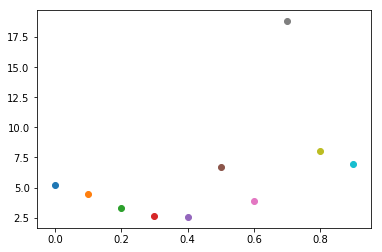

In [46]:
from glob import glob

paths = sorted(glob('results/*.npy'))

b_grid = np.arange(0, 1, 0.1)

for i, path in enumerate(paths): 
    
    s = np.load(path)
    print(path)
#     plt.hist(s[:, 2], color='k')
#     plt.show()

    lower, mid, upper = np.percentile(s[:, 2], [16, 50, 84])
    upper_one_sigma = 100 * (upper - mid) / s[:, 2].mean()
    lower_one_sigma = 100 * (mid - lower) / s[:, 2].mean()


#     plt.scatter(b_grid[i], 100 * s[:, 2].std() / s[:, 2].mean())
    plt.scatter(b_grid[i], upper_one_sigma)

#     plt.scatter(b_grid[i], lower_one_sigma)

    
#     corner(s)
#     plt.show()

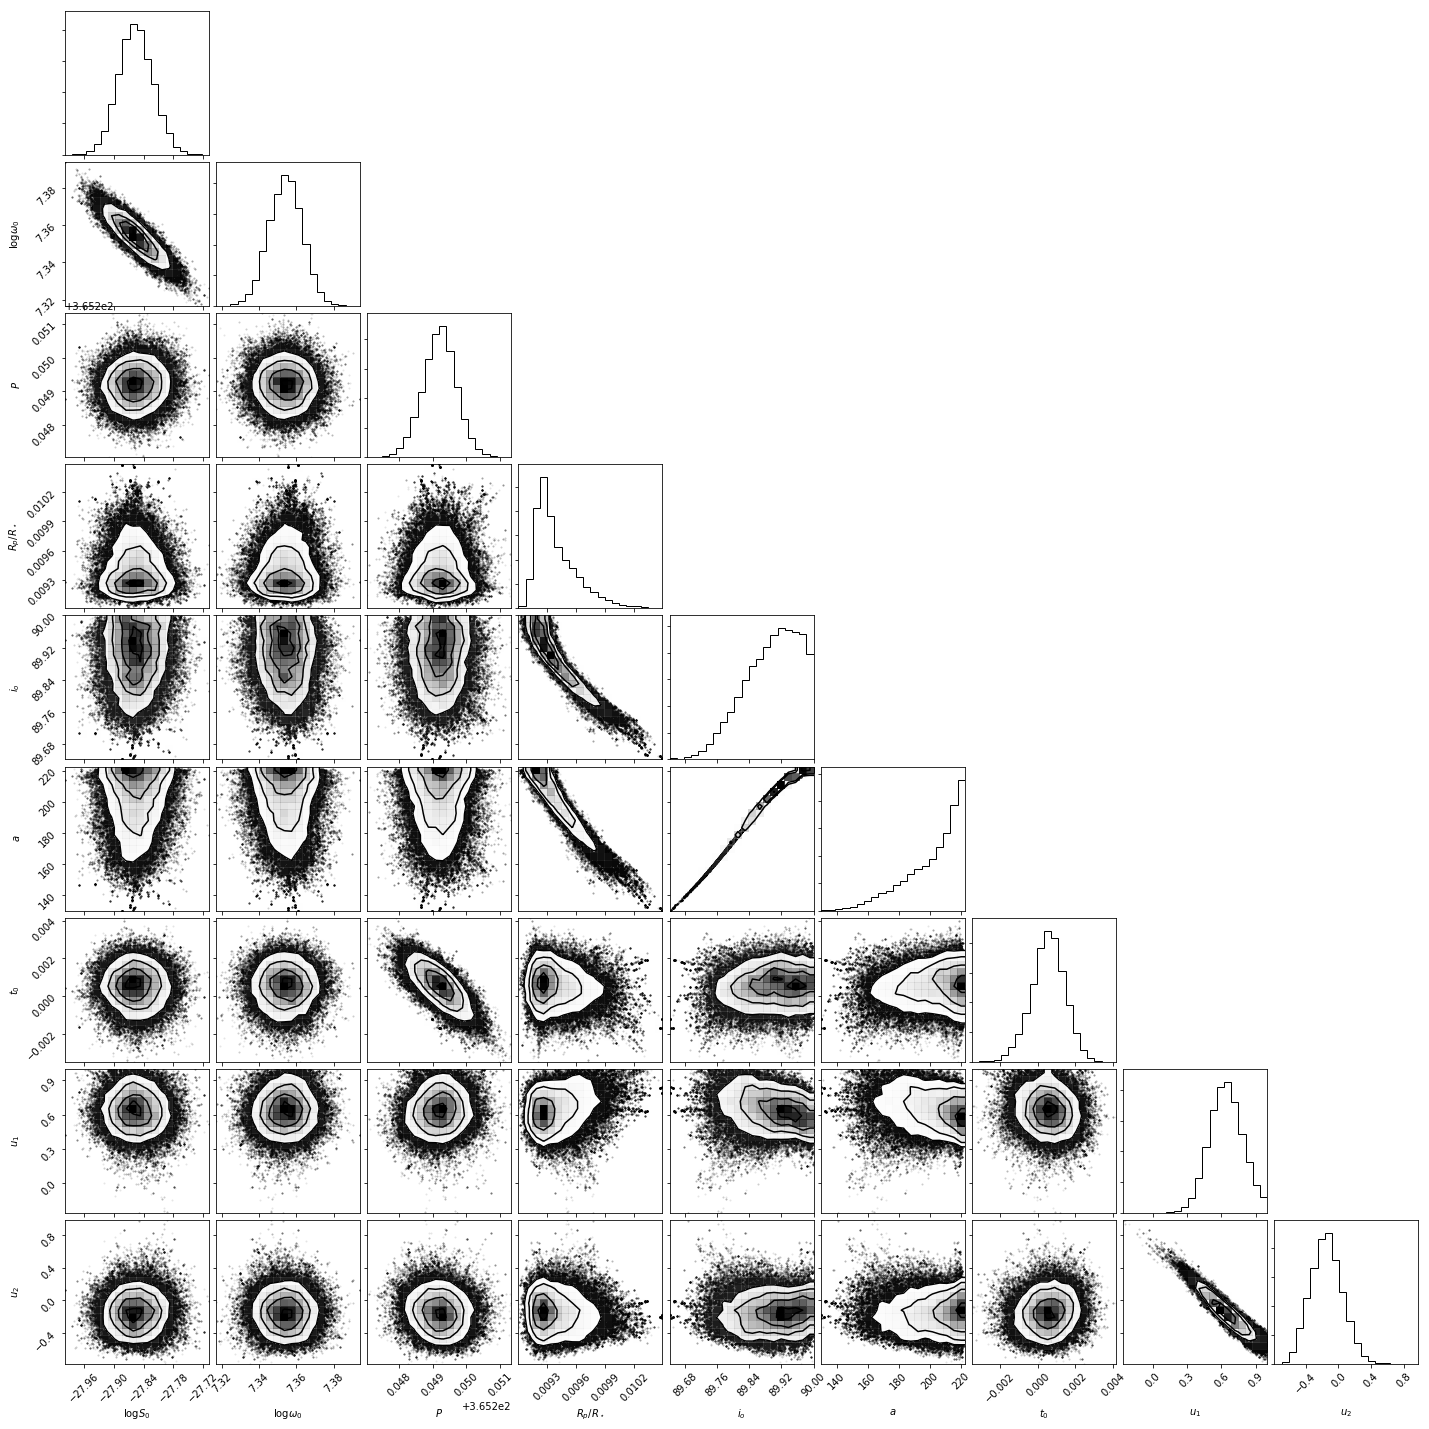

In [189]:
# from corner import corner

# corner(sampler.flatchain, labels=["${0}$".format(i) for i in "\log S_0,\log \omega_0,P,R_p/R_\star,i_o,a,t_0,u_1,u_2".split(',')]);
#                                   #"\log a,\log c,\log P,R_p/R_\star,i_o,a,t_0,u_1,u_2".split(',')]);
# plt.savefig("paper_plots/corner_float_per_b05.pdf", bbox_inches='tight')
# plt.show()

0.023472799655498273

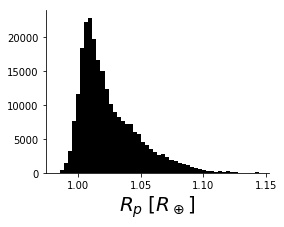

In [190]:
from astropy.constants import R_sun, R_earth

plt.figure(figsize=(4, 3))
plt.hist(sampler.flatchain[:,3] / (R_earth/R_sun), bins=50, color='k', histtype='stepfilled')#, range=[0.8, 1.2]);
plt.xlabel("$R_p \; [R_\oplus]$", fontsize=20)
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.savefig('paper_plots/radius_posterior_floatperiod_b05.pdf', bbox_inches='tight')
sampler.flatchain[:, 3].std() / sampler.flatchain[:, 3].mean()

In [191]:
rprs = sampler.flatchain[:, 3]
b = sampler.flatchain[:, 5] * np.cos(np.radians(sampler.flatchain[:, 4]))
u1 = sampler.flatchain[:, -2]
u2 = sampler.flatchain[:, -1]

In [192]:
rprs.std()/rprs.mean()

0.023472799655498273

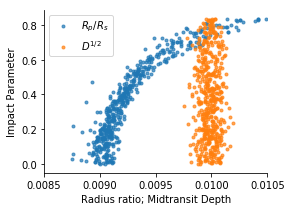

In [40]:


sqrt_D = np.sqrt( rprs**2 * (1 - u1*(1-np.sqrt(1-b**2)) - u2*(1-np.sqrt(1 - b**2))**2)/ (1 - u1/3 - u2/6) )

skip = 500
plt.figure(figsize=(4,3))
plt.scatter(rprs[::skip], b[::skip], marker='.', alpha=0.7, label='$R_p/R_s$')
plt.scatter(sqrt_D[::skip], b[::skip], marker='.', alpha=0.7, label='$D^{1/2}$')
plt.legend()
plt.xlabel('Radius ratio; Midtransit Depth')
plt.ylabel('Impact Parameter')
for s in 'right top'.split():
    plt.gca().spines[s].set_visible(False)
plt.xlim([0.0085, 0.0105])
plt.savefig('paper_plots/radius_ratio_depth_vs_impact_parameter.pdf', bbox_inches='tight')

In [42]:
100 * sqrt_D.std()

0.0073411252026613898